In [79]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time, sys
from IPython.display import clear_output
%matplotlib inline

In [124]:
class SOM(nn.Module):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
    def __init__(self, m, n, dim, niter, alpha=None, sigma=None):
        """
        Initializes all necessary components of the TensorFlow
        Graph.
 
        m X n are the dimensions of the SOM. 'n_iterations' should
        should be an integer denoting the number of iterations undergone
        while training.
        'dim' is the dimensionality of the training inputs.
        'alpha' is a number denoting the initial time(iteration no)-based
        learning rate. Default value is 0.3
        'sigma' is the the initial neighbourhood value, denoting
        the radius of influence of the BMU while training. By default, its
        taken to be half of max(m, n).
        """
        super(SOM, self).__init__()
        self.m = m
        self.n = n
        self.dim = dim
        self.niter = niter
        if alpha is None:
            self.alpha = 0.3
        else:
            self.alpha = float(alpha)
        if sigma is None:
            self.sigma = max(m, n) / 2.0
        else:
            self.sigma = float(sigma)

        self.weights = torch.randn(m*n, dim)
        self.locations = torch.LongTensor(np.array(list(self.neuron_locations())))
        self.pdist = nn.PairwiseDistance(p=2)

    def get_weights(self):
        return self.weights

    def get_locations(self):
        return self.locations

    def neuron_locations(self):
        for i in range(self.m):
            for j in range(self.n):
                yield np.array([i, j])

    def map_vects(self, input_vects):
        to_return = []
        for vect in input_vects:
            dists = self.pdist(torch.stack([vect for i in range(self.m*self.n)]), self.weights)
            bmu_index = torch.min(dists, 0)
            bmu_loc = self.locations[bmu_index,:]
            bmu_loc = bmu_loc.squeeze()
            to_return.append(bmu_loc)

        return to_return

    def forward(self, x, it):
        #расстояния между вектором и весами
        dists = self.pdist(torch.stack([x for i in range(self.m*self.n)]), self.weights)
        #индекс минимального расстояния
        _, bmu_index = torch.min(dists, 0)
        #выбор пары (х, у) для мин значения
        bmu_loc = self.locations[bmu_index,:]
        #оставление только размерности (2,)
        bmu_loc = bmu_loc.squeeze()
        
        #уменьшение лр
        learning_rate_op = 1.0 - it/self.niter
        #
        alpha_op = self.alpha * learning_rate_op
        #радиус
        sigma_op = self.sigma * learning_rate_op

        #находжение расстояний на карте
        bmu_distance_squares = torch.sqrt(torch.sum(torch.pow(self.locations.float() - torch.stack([bmu_loc for i in range(self.m*self.n)]).float(), 2), 1))
        #влияние соседей
        neighbourhood_func = torch.exp(torch.neg(torch.div(bmu_distance_squares, sigma_op**2)))
        
        #new_w = w + (learning_rate_op * neighbourhood_func * (x - w))
        learning_rate_op = alpha_op * neighbourhood_func
        learning_rate_multiplier = torch.stack([learning_rate_op[i:i+1].repeat(self.dim) for i in range(self.m*self.n)])
        delta = torch.mul(learning_rate_multiplier, (torch.stack([x for i in range(self.m*self.n)]) - self.weights))                                         
        new_weights = torch.add(self.weights, delta)
        self.weights = new_weights


In [122]:
data = pd.read_csv("D:/Wine.txt", sep=',')
target = data.Class.values
train_df = data.drop(['Class'], axis=1)
dim = len(train_df.columns)
target_names = ['Wine 1', 'Wine 2', 'Wine 3']
normalized_df=(train_df-train_df.mean())/train_df.std()
#normalized_df=(data-data.min())/(data.max()-data.min())
#print(normalized_df.groupby('Class').mean())
data = torch.FloatTensor(normalized_df.values)
print(data.shape)

torch.Size([178, 13])


In [125]:
%%time
m = 20
n = 20
#Train a 20x20 SOM with 100 iterations
n_iter = 200
som = SOM(m, n, dim, n_iter)
for iter_no in range(n_iter):
    #Train with each vector one by one
    clear_output()
    print(iter_no+1, '%')
    for i in range(len(data)):
        som(data[i], iter_no)   

200 %
Wall time: 39min 51s


In [126]:
weights = som.get_weights()
locations = som.get_locations()

#Store a centroid grid for easy retrieval later on
centroid_grid = [[] for i in range(m)]


for i, loc in enumerate(locations):
    centroid_grid[loc[0]].append(weights[i])

#Map colours to their closest neurons
mapped = som.map_vects(data)

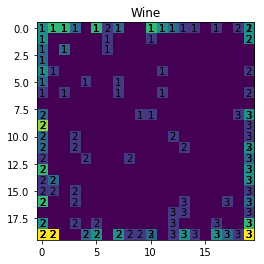

In [127]:
#Plot
plt_map = np.zeros((m, n))
for a in mapped:
    plt_map[a[0]][a[1]] += 1
plt.imshow(plt_map)
plt.title('Wine')
for i, mp in enumerate(mapped):
    plt.text(mp[1], mp[0], target[i], ha='center', va='center')
plt.show()

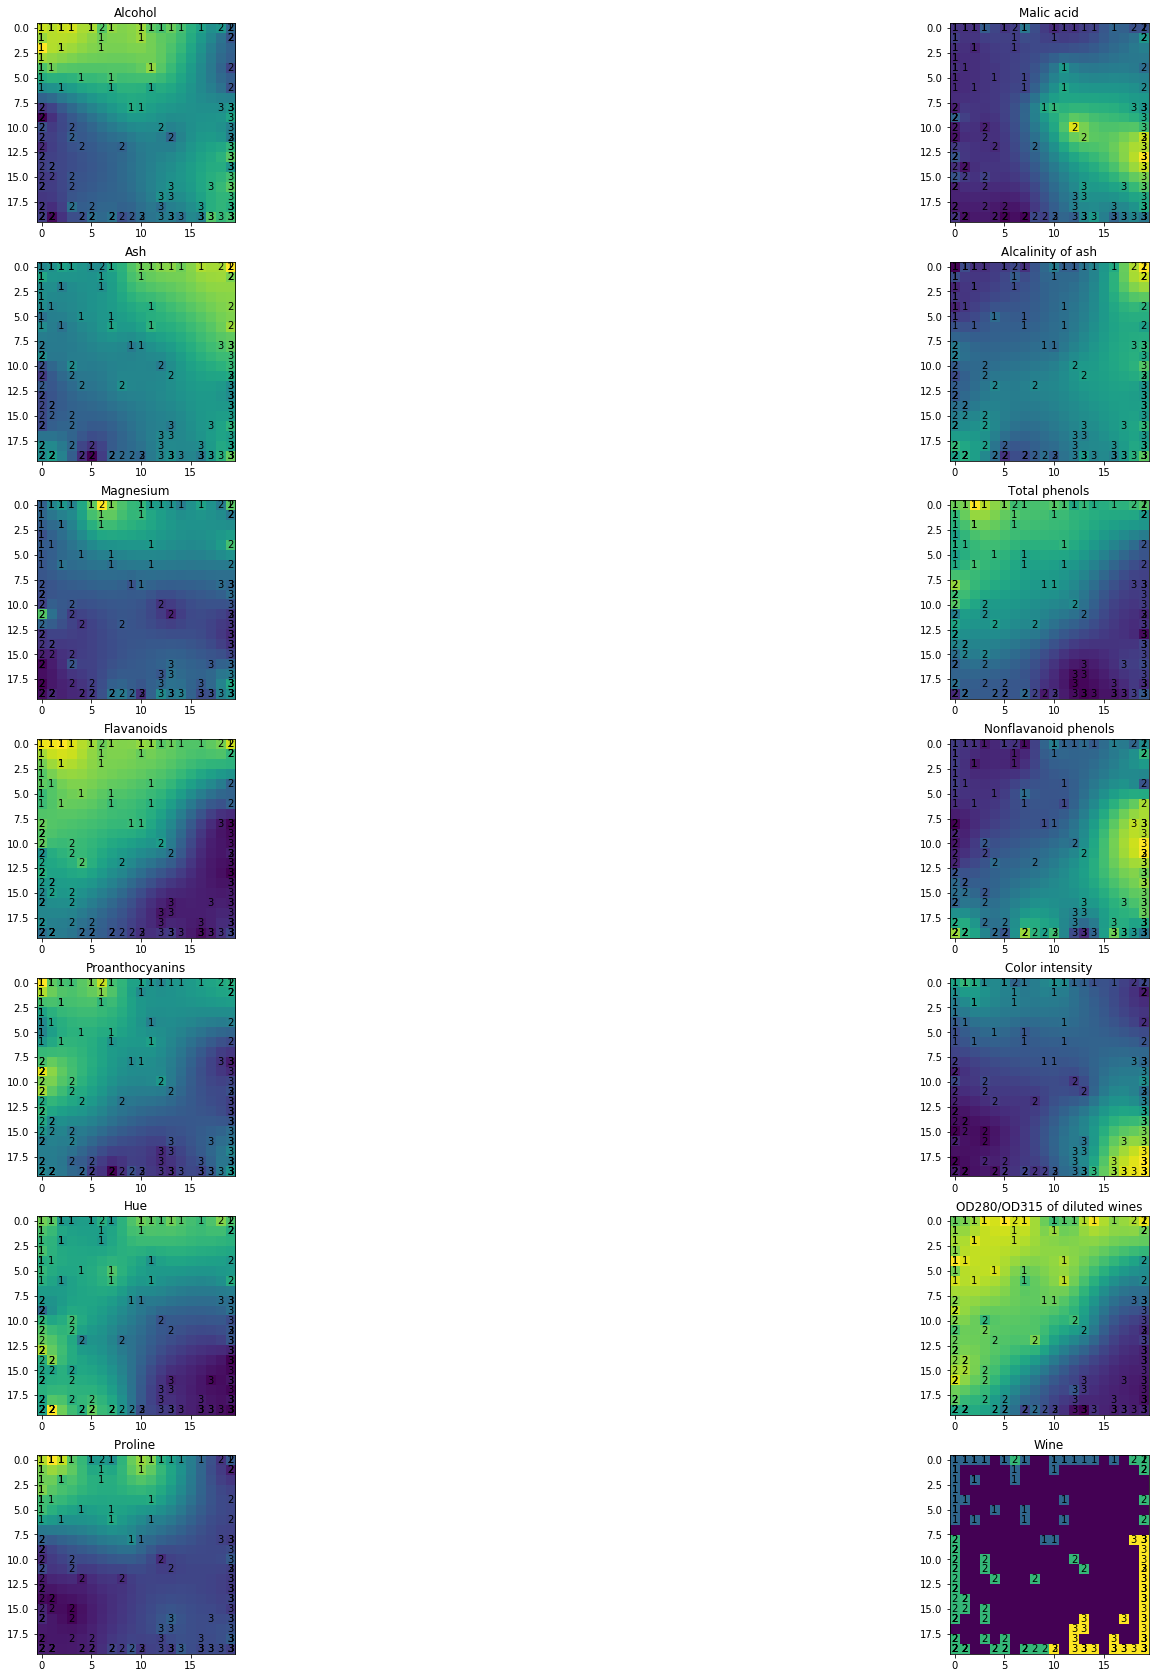

In [128]:
plt_w = np.zeros((m, n))
fig, axes = plt.subplots(7, 2,  figsize = (30, 30))
for i in range(dim):
    x = i//2
    y = i%2
    
    for mg in range(m):
        for ng in range(n):
            plt_w[mg][ng] = centroid_grid[mg][ng][i]
    axes[x, y].imshow(plt_w)
    axes[x, y].set_title(list(train_df.columns.values)[i])
    for ii, mp in enumerate(mapped):
        axes[x, y].text(mp[1], mp[0], target[ii], ha='center', va='center')
        
plt_w = np.zeros((m, n))
for ii, mp in enumerate(mapped):
    plt_w[mp[0]][mp[1]] =target[ii]
axes[6, 1].imshow(plt_w)
axes[6, 1].set_title('Wine')
for ii, mp in enumerate(mapped):
    axes[6, 1].text(mp[1], mp[0], target[ii], ha='center', va='center')
plt.show()